# **🏠 부동산 실거래가 Baseline code**
> 부동산 실거래가 예측 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 RandomForest를 활용해 ML 방법론들을 실제 대회에 적용해보도록 하겠습니다.
> 강의는 google colab으로 실행하였기에 아래의 베이스라인 코드와는 일부 차이가 있을 수 있습니다. 

## Contents
- Library Import
- Data Load
- Data Preprocessing
- Feature Engineering
- Model Training
- Inference
- Output File Save


## 1. Library Import
- 필요한 라이브러리를 불러옵니다.

In [5]:
# !pip install eli5==0.13.0
%pip install eli5==0.13.0


Note: you may need to restart the kernel to use updated packages.


In [4]:

# 한글 폰트 사용을 위한 라이브러리입니다.
# !apt-get install -y fonts-nanum
!apt-get install -y fonts-nanum

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

## 2. Data Load

#### 2.1. 데이터 로드

In [105]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = '/data/ephemeral/home/train.csv'
test_path  = '/data/ephemeral/home/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

In [106]:
# Train data와 Test data shape은 아래와 같습니다.
print('Train data shape : ', dt.shape, 'Test data shape : ', dt_test.shape)

Train data shape :  (1118822, 52) Test data shape :  (9272, 51)


In [107]:
# Train과 Test data를 살펴보겠습니다.
display(dt.head(1))
display(dt_test.head(1))      # 부동산 실거래가(=Target) column이 제외된 모습입니다.

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000


,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,202307,26,5,1987,...,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0


In [108]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

<Axes: >

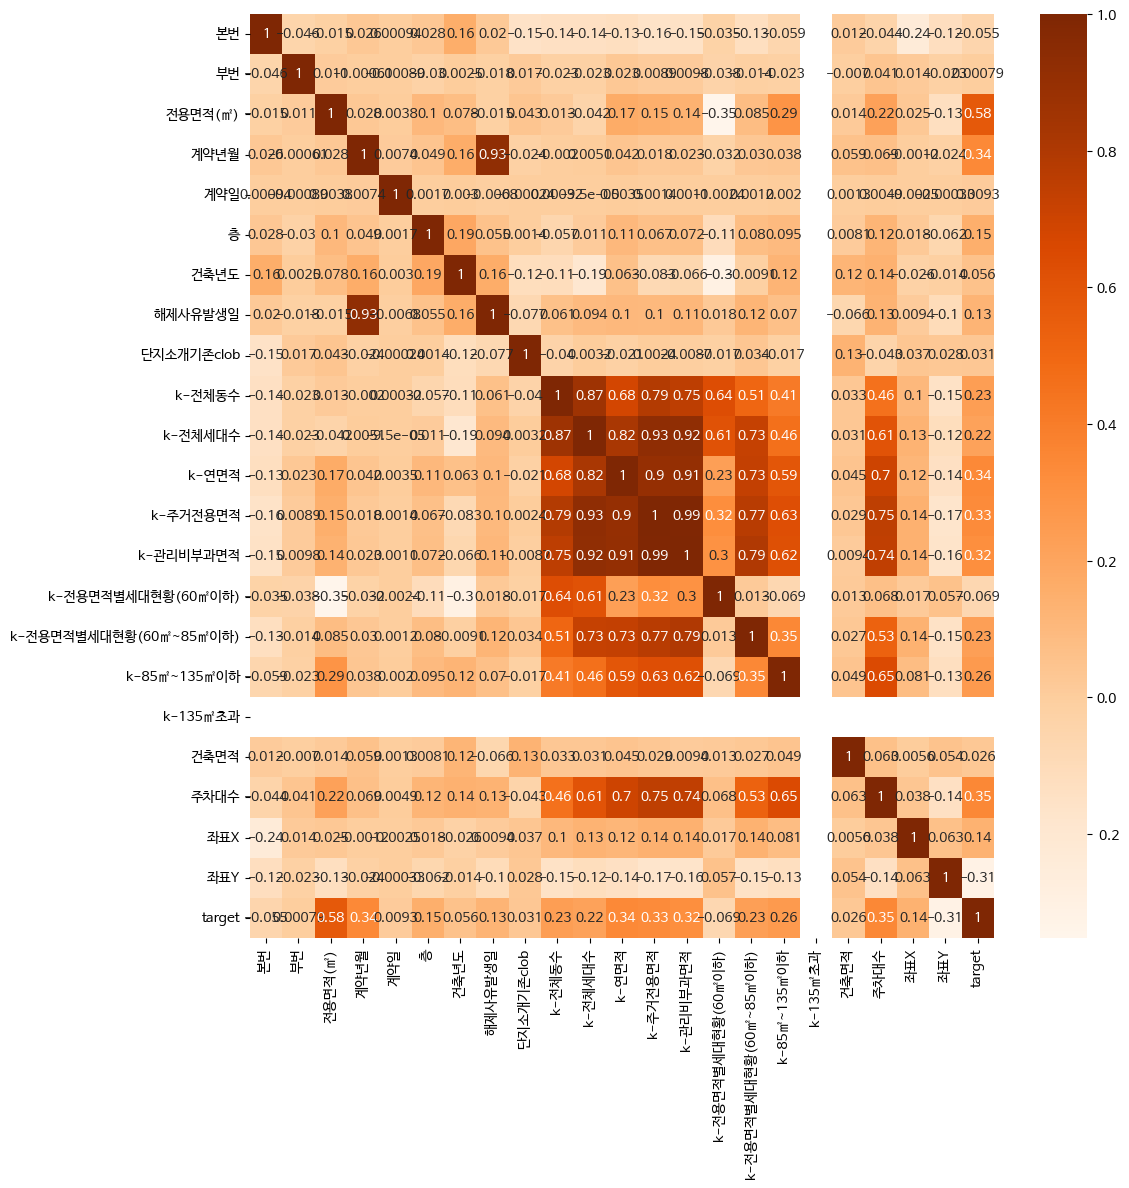

In [109]:
import seaborn as sns

plt.figure(figsize=(12,12))
ft_corr_matrix = dt.corr()
sns.heatmap(ft_corr_matrix, annot=True, cmap='Oranges')

In [110]:
# feature간 상관관계 순서대로- 상관관계 높은 Feature를 확인.
value_sorted = ft_corr_matrix.unstack().sort_values(ascending=False)
value_sorted.drop_duplicates()[:20]

본번         본번                        1.000000
k-관리비부과면적  k-주거전용면적                  0.991215
k-주거전용면적   k-전체세대수                   0.929210
계약년월       해제사유발생일                   0.925681
k-관리비부과면적  k-전체세대수                   0.921836
           k-연면적                     0.905407
k-주거전용면적   k-연면적                     0.902912
k-전체동수     k-전체세대수                   0.866366
k-연면적      k-전체세대수                   0.817471
k-관리비부과면적  k-전용면적별세대현황(60㎡~85㎡이하)    0.794802
k-주거전용면적   k-전체동수                    0.785901
           k-전용면적별세대현황(60㎡~85㎡이하)    0.771122
k-전체동수     k-관리비부과면적                 0.753234
주차대수       k-주거전용면적                  0.746538
           k-관리비부과면적                 0.743562
k-연면적      k-전용면적별세대현황(60㎡~85㎡이하)    0.731519
k-전체세대수    k-전용면적별세대현황(60㎡~85㎡이하)    0.726240
k-연면적      주차대수                      0.704097
k-전체동수     k-연면적                     0.681231
주차대수       k-85㎡~135㎡이하              0.650161
dtype: float64

## 3. Data Preprocessing

- 모델링 전에 데이터 내 결측치, 이상치 등을 제거하고 범주형과 연속형 변수를 살펴보도록 하겠습니다!
- 먼저, 용이한 전처리를 위해 train과 test data를 합친 하나의 데이터로 진행하도록 하겠습니다.

In [111]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt['is_test'] = 0
dt_test['is_test'] = 1
concat = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [112]:
concat.head()

,시군구,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,...,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,124000.0,0
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,123500.0,0
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,54.98,201712,28,5,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,91500.0,0
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,3,4,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,130000.0,0
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201801,8,2,1987,...,262.0,임의,2022-11-17 13:00:29.0,Y,N,127.05721,37.476763,2022-11-17 10:19:06.0,117000.0,0


In [113]:
concat['is_test'].value_counts()      # train과 test data가 하나로 합쳐진 것을 확인할 수 있습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

In [114]:
# 칼럼 이름을 쉽게 바꿔주겠습니다. 다른 칼럼도 사용에 따라 바꿔주셔도 됩니다!
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

### 3.1. 결측치 탐색 및 보간
- 결측치를 처리할 때 많이 쓰는 방법은 삭제(Deletion)과 대체(Imputation) 입니다.
- 본 Baseline에서는 결측치가 90% 이상을 차지하는 변수의 결측치는 제거하고, 나머지 결측치는 대체하도록 하겠습니다.
  - 연속형 변수의 경우에는 선형보간(Linear interpolation)으로 대체하겠습니다.
  - 범주형 변수의 경우에는 'NULL' 이라는 임의의 범주로 대체해주도록 하겠습니다.

- 참고 ✅
  - 선형보간(Linear interpolation)이란 두 점의 값이 주어졌을 때 **그 사이의 값**을 추정하기 위해 직선 거리에 따라 선형적으로 계산하는 방법입니다.
  - 아래 두개의 붉은 점 사이에 ($x$, $y$) 값을 추정하기 위해, 해당 점이 두 붉은 점을 이은 선형적인 선분에 있다고 가정하고, 단순 비례식으로 ($x$, $y$)를 추정해 보간하는 방법입니다.
  - [참고자료](https://ko.wikipedia.org/wiki/%EC%84%A0%ED%98%95_%EB%B3%B4%EA%B0%84%EB%B2%95#:~:text=%EC%84%A0%ED%98%95%20%EB%B3%B4%EA%B0%84%EB%B2%95(%E7%B7%9A%E5%9E%8B%E8%A3%9C%E9%96%93%E6%B3%95,%EC%9C%BC%EB%A1%9C%20%EA%B3%84%EC%82%B0%ED%95%98%EB%8A%94%20%EB%B0%A9%EB%B2%95%EC%9D%B4%EB%8B%A4.)


> 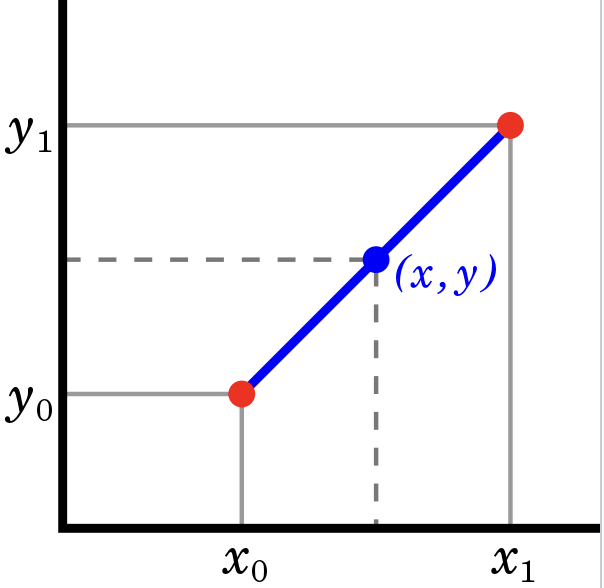

In [12]:
# 실제로 결측치라고 표시는 안되어있지만 아무 의미도 갖지 않는 element들이 아래와 같이 존재합니다.
# 아래 3가지의 경우 모두 아무 의미도 갖지 않는 element가 포함되어 있습니다.
# display(concat['등기신청일자'].value_counts())

            1111271
20230630        585
20230831        496
20230428        394
20230731        374
             ...   
20230105          3
20230125          3
20230109          1
20230102          1
20230104          1
Name: 등기신청일자, Length: 182, dtype: int64

In [13]:
# display(concat['거래유형'].value_counts())

-       1086451
중개거래      38123
직거래        3520
Name: 거래유형, dtype: int64

In [14]:
# display(concat['중개사소재지'].value_counts())

-                    1090013
서울 노원구                  2627
서울 송파구                  2540
서울 강남구                  2508
서울 강동구                  2038
                      ...   
서울 강북구, 서울 양천구             1
경기 남양주시, 경기 성남수정구          1
서울 송파구, 인천 계양구             1
경기 연천군, 서울 송파구             1
서울 중랑구, 인천 부평구             1
Name: 중개사소재지, Length: 739, dtype: int64

In [115]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [116]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                    1111271
거래유형                      1086451
중개사소재지                    1090013
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

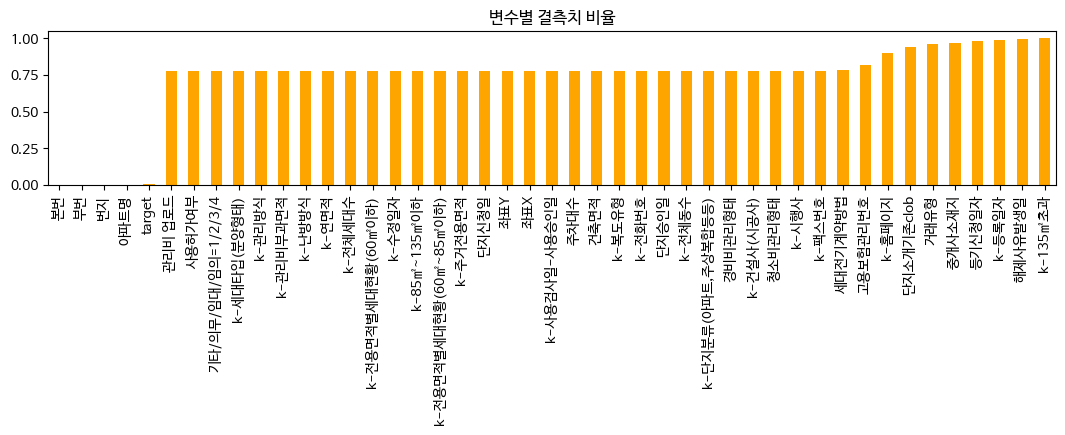

In [117]:
# 변수별 결측치의 비율을 plot으로 그려보면 아래와 같습니다.
fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()

- 위 그래프에서 볼 수 있다시피 결측치가 100만개 이상인 칼럼들은 결측치가 해당 칼럼의 element 중 90% 이상을 차지하는 상황이 됩니다.
- 따라서 본 Baseline 에서는 이 칼럼은 예측에 도움이 되지 않는다고 판단해 삭제해주도록 하겠습니다.

In [18]:
# Null값이 100만개 이상인 칼럼은 삭제해보도록 하겠습니다.
# print('* 결측치가 100만개 이하인 변수들 :', list(concat.columns[concat.isnull().sum() <= 1000000]))     # 남겨질 변수들은 아래와 같습니다.
# print('* 결측치가 100만개 이상인 변수들 :', list(concat.columns[concat.isnull().sum() >= 1000000]))

* 결측치가 100만개 이하인 변수들 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
* 결측치가 100만개 이상인 변수들 : ['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [118]:
# 위에서 결측치가 10만개 이하인 변수들만 골라 새로운 concat_select 객체로 저장해줍니다.
selected = list(concat.columns[concat.isnull().sum() <= 100000])
concat_select = concat[selected]
# 100만개 기준을 10만개로 변경 2024.7.17

In [119]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도',
       '도로명', 'target', 'is_test'],
      dtype='object')

In [120]:
concat_select.isnull().sum()     # 결측치가 10만개 초과인 칼럼이 제거된 모습은 아래와 같습니다.
# target변수는 test dataset 개수만큼(9272) 결측치가 존재함을 확인할 수 있습니다.

시군구           0
번지          227
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
dtype: int64

In [121]:
display(concat[['번지', '아파트명']].value_counts())

번지      아파트명     
17      파크리오         4372
1353    에스케이북한산시티    4049
502-1   중계그린1단지      3327
1712    관악드림         3197
22      리센츠          3088
                     ... 
728-6   마이다스힐빌라트        1
87-5    수유시그니티          1
227-12  밀란체             1
400-1   신수동르끌레브         1
8-27    신사레전드           1
Length: 8702, dtype: int64

In [122]:
# 번지 데이터 수동 작업
nulladress = concat.loc[concat['번지'].isna(), ['번지', '아파트명']]

In [123]:
nulladress.groupby(by='아파트명').count()

,번지
아파트명,
서초포레스타2단지,0
힐스테이트 서초 젠트리스,0


In [124]:
concat.loc[concat['번지'].isna(), ['아파트명']].value_counts()

아파트명         
서초포레스타2단지        152
힐스테이트 서초 젠트리스     75
dtype: int64

In [125]:
concat.loc[concat['아파트명']=='힐스테이트 서초 젠트리스', '시군구']

# 힐스테이트 서초 젠트리스 = 557
# 서초포레스타2단지 = 384

60194     서울특별시 서초구 신원동
60195     서울특별시 서초구 신원동
60196     서울특별시 서초구 신원동
60197     서울특별시 서초구 신원동
60198     서울특별시 서초구 신원동
              ...      
720188    서울특별시 서초구 신원동
720189    서울특별시 서초구 신원동
720190    서울특별시 서초구 신원동
720191    서울특별시 서초구 신원동
720192    서울특별시 서초구 신원동
Name: 시군구, Length: 75, dtype: object

In [128]:
# 아파트명에 대한 번지 데이터 입력
concat_select.loc[concat_select['아파트명'] == '힐스테이트 서초 젠트리스', '번지'] = '557'
concat_select.loc[concat_select['아파트명'] == '서초포레스타2단지', '번지'] = '384'

In [129]:
concat_select.isnull().sum()

시군구           0
번지            0
본번           75
부번           75
아파트명       2136
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
dtype: int64

In [130]:
concat.groupby('도로명')['아파트명'].value_counts()


도로명        아파트명    
           신내우디안1단지    488
           신내 데시앙포레    241
           반도1차         50
           평화           50
           다청림라인씨티      43
                      ... 
희우정로17길 9  태경크레앙스       11
희우정로1길 21  삼성강변         10
희우정로1길 27  백운            9
희우정로1길 48  두영이지안        35
희우정로21길 5  리버뷰          11
Name: 아파트명, Length: 9152, dtype: int64

In [131]:
# 신내우디안1단지
concat.loc[concat['아파트명']=='신내우디안1단지','도로명'].value_counts()

             488
신내역로1길 85    218
Name: 도로명, dtype: int64

In [132]:
concat_select['아파트명'] = concat_select.groupby('도로명')['아파트명'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

In [133]:
concat_select.isnull().sum()

시군구           0
번지            0
본번           75
부번           75
아파트명       2130
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
dtype: int64

In [134]:
concat_select.loc[concat_select['도로명'] == '천호대로77다길 11-6', '아파트명'] = '해오름아파트'
concat_select.loc[concat_select['도로명'] == '동호로11마길 20-8', '아파트명'] = '성민아트'
concat_select.loc[concat_select['도로명'] == '여의대방로62길 24', '아파트명'] = '효성아파트'
concat_select.loc[concat_select['도로명'] == '국사봉1길 18', '아파트명'] = '상진빌딩'
concat_select.loc[concat_select['도로명'] == '동호로11바길 30-8', '아파트명'] = '석종아파트'
concat_select.loc[concat_select['도로명'] == '신수로 89', '아파트명'] = '신수동 자이언트 아파트'
concat_select.loc[concat_select['도로명'] == '양재대로71길 2-11', '아파트명'] = '올림픽아트빌'
concat_select.loc[concat_select['도로명'] == '청계천로 295', '아파트명'] = '동대문신발상가'
concat_select.loc[concat_select['도로명'] == '대학로7길 15-4', '아파트명'] = '연건동아파트'
concat_select.loc[concat_select['도로명'] == '강남대로27길 7-14', '아파트명'] = '한일인텔빌라'
concat_select.loc[concat_select['도로명'] == '명륜2길 9-14', '아파트명'] = '명륜2길 9-14'
concat_select.loc[concat_select['도로명'] == '동호로5길 12', '아파트명'] = '다다유크레스'
concat_select.loc[concat_select['도로명'] == '증산로23길 8-8', '아파트명'] = '우일아파트'
concat_select.loc[concat_select['도로명'] == '낙산성곽동길 35-1', '아파트명'] = '낙산성곽동길 35-1'
concat_select.loc[concat_select['도로명'] == '서리풀길 14', '아파트명'] = 'callia vill'
concat_select.loc[concat_select['도로명'] == '효령로 200', '아파트명'] = '효령로 200'
concat_select.loc[concat_select['도로명'] == '화곡로 176-5', '아파트명'] = '화곡로 176-5'
concat_select.loc[concat_select['도로명'] == '광나루로12길 5', '아파트명'] = '광나루로12길 5'
concat_select.loc[concat_select['도로명'] == '개운사길 83-15', '아파트명'] = '개운사길 83-15'
concat_select.loc[concat_select['도로명'] == '도곡로93길 23', '아파트명'] = '대치 르엘'
concat_select.loc[concat_select['도로명'] == '까치산로14길 26-13', '아파트명'] = '힐탑아파트'
concat_select.loc[concat_select['도로명'] == '양천로 677', '아파트명'] = '염창하이츠빌딩'
concat_select.loc[concat_select['도로명'] == '천호대로118길 10', '아파트명'] = '천호대로118길 10'
concat_select.loc[concat_select['도로명'] == '난계로15길 36-6', '아파트명'] = '난계로15길 36-6'
concat_select.loc[concat_select['도로명'] == '난계로15길 36-8', '아파트명'] = '난계로15길 36-8'
concat_select.loc[concat_select['도로명'] == '이문로35아길 16', '도로명'] = '이문로16길 35' # 잘못된 도로명 주소 수정
concat_select.loc[concat_select['도로명'] == '이문로16길 35', '아파트명'] = '이문로16길 35'
concat_select.loc[concat_select['도로명'] == '마조로1길 45', '아파트명'] = '아파트'
concat_select.loc[concat_select['도로명'] == '성지3길 7', '아파트명'] = '성지3길 7'

In [135]:
concat_select.isnull().sum()

시군구           0
번지            0
본번           75
부번           75
아파트명       1822
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
dtype: int64

In [143]:
concat_select['아파트명'] = concat_select.apply(lambda row: row['도로명'] if (row['시군구'] == '서울특별시 구로구 구로동' and pd.isna(row['아파트명']) and ('구로동로' in row['도로명'] or '도림로' in row['도로명'] or '디지털로' in row['도로명'])) else row['아파트명'], axis=1)

In [144]:
concat_select.isnull().sum()

시군구           0
번지            0
본번            0
부번            0
아파트명        200
전용면적          0
계약년월          0
계약일           0
층             0
건축년도          0
도로명           0
target     9272
is_test       0
dtype: int64

<Axes: >

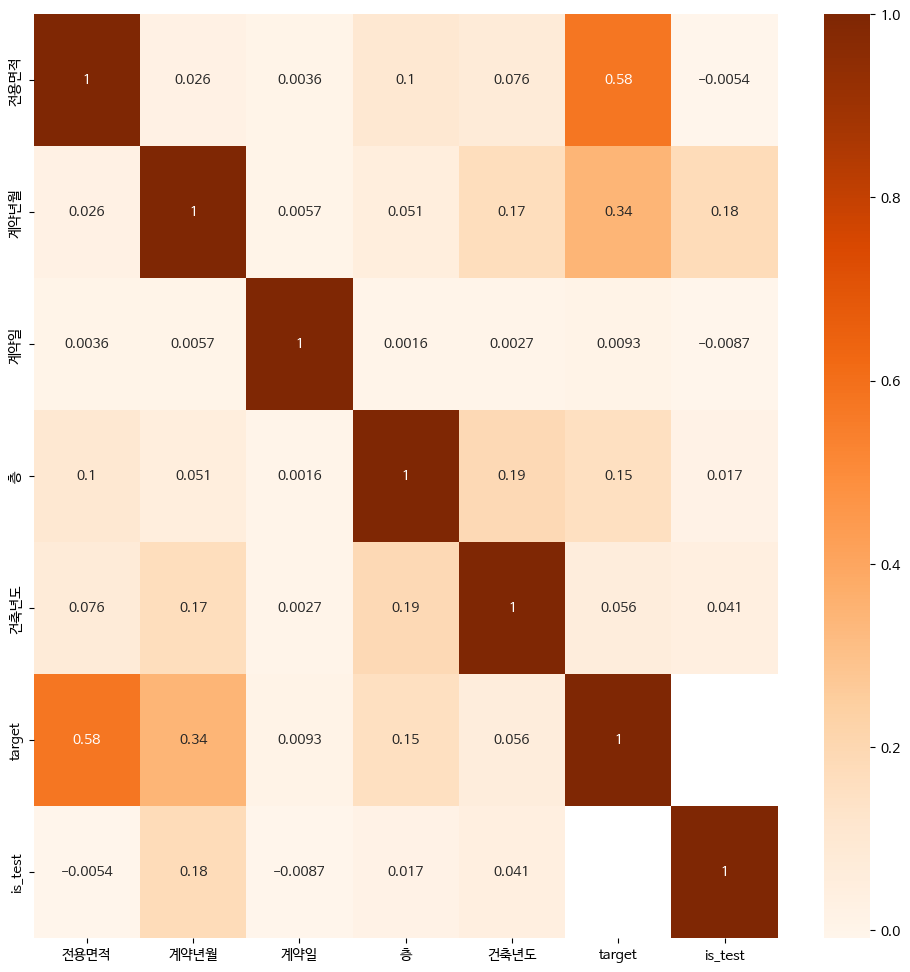

In [145]:

plt.figure(figsize=(12,12))
ft_corr_matrix = concat_select.corr()
sns.heatmap(ft_corr_matrix, annot=True, cmap='Oranges')

In [146]:
# 연속형 변수는 선형보간을 해주고, 범주형변수는 알수없기에 “unknown”이라고 임의로 보간해 주겠습니다.
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 13 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   번지       1128094 non-null  object 
 2   본번       1128094 non-null  object 
 3   부번       1128094 non-null  object 
 4   아파트명     1127894 non-null  object 
 5   전용면적     1128094 non-null  float64
 6   계약년월     1128094 non-null  int64  
 7   계약일      1128094 non-null  int64  
 8   층        1128094 non-null  int64  
 9   건축년도     1128094 non-null  int64  
 10  도로명      1128094 non-null  object 
 11  target   1118822 non-null  float64
 12  is_test  1128094 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 120.5+ MB


In [140]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
concat_select['본번'] = concat_select['본번'].astype('str')
concat_select['부번'] = concat_select['부번'].astype('str')

In [141]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat_select.columns:
    if pd.api.types.is_numeric_dtype(concat_select[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']
범주형 변수: ['시군구', '번지', '본번', '부번', '아파트명', '도로명']


- 연속형 변수와 범주형 변수가 알맞게 나누어졌는지 확인해보고, 이제 각각 보간을 진행합니다.

In [147]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns] = concat_select[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns] = concat_select[continuous_columns].interpolate(method='linear', axis=0)

In [148]:
concat_select.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

시군구        0
번지         0
본번         0
부번         0
아파트명       0
전용면적       0
계약년월       0
계약일        0
층          0
건축년도       0
도로명        0
target     0
is_test    0
dtype: int64

- Baseline에서는 단순 결측치들을 제거하거나 보간했지만,
EDA를 통해 변수들의 흐름을 조금 더 파악하고 더 나은 interpolation 등의 방법을 고려해볼 수 있을 것 같습니다.

### 3.2. 이상치 처리
- 이번엔 이상치를 처리해봅시다.
- 이상치를 처리하는 방법은 IQR, Z-score 등 다양한 방법이 있습니다. 가장 쉽고 직관적으로 접근하는 방법은 기본 통계치를 이용하는 것입니다.
- 본 baseline에서는 IQR를 이용한 방법을 사용하겠습니다.

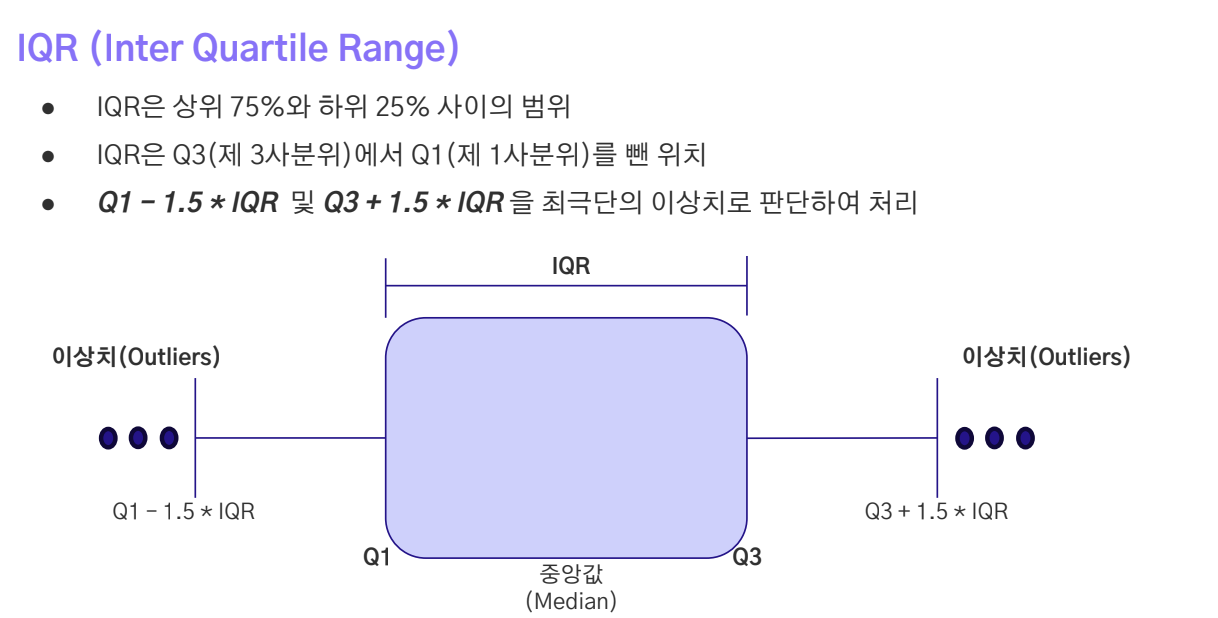

In [149]:
# 이상치 제거 이전의 shape은 아래와 같습니다.
print(concat_select.shape)

(1128094, 13)


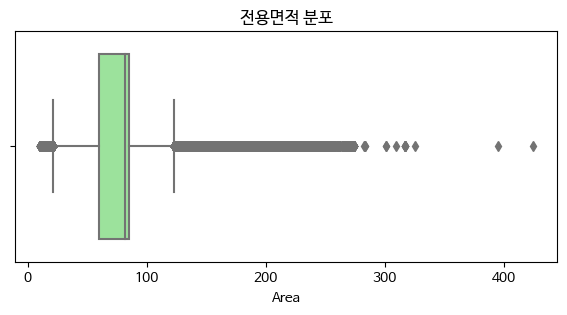

In [150]:
# 대표적인 연속형 변수인 “전용 면적” 변수 관련한 분포를 먼저 살펴보도록 하겠습니다.
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = concat_select, x = '전용면적', color='lightgreen')
plt.title('전용면적 분포')
plt.xlabel('Area')
plt.show()

In [42]:
# 이상치 제거 방법에는 IQR을 이용하겠습니다.
# def remove_outliers_iqr(dt, column_name):
#     df = dt.query('is_test == 0')       # train data 내에 있는 이상치만 제거하도록 하겠습니다.
#     df_test = dt.query('is_test == 1')

#     Q1 = df[column_name].quantile(0.25)
#     Q3 = df[column_name].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

#     result = pd.concat([df, df_test])   # test data와 다시 합쳐주겠습니다.
#     return result

In [43]:
# 위 방법으로 전용 면적에 대한 이상치를 제거해보겠습니다.
# concat_select = remove_outliers_iqr(concat_select, '전용면적')

In [151]:
# 이상치 제거 후의 shape은 아래와 같습니다. 약 10만개의 데이터가 제거된 모습을 확인할 수 있습니다.
print(concat_select.shape)

(1128094, 13)


In [152]:
concat_select['is_test'].value_counts()     # 또한, train data만 제거되었습니다.

0    1118822
1       9272
Name: is_test, dtype: int64

## 4. Feature Engineering
- 이제 파생변수를 만들어보도록 하겠습니다.
- 파생 변수는 도메인 지식에 기반해 제작하는 것이 중요합니다.
- 주택의 가격을 예측하는 문제이기 때문에 약간의 부동산 지식을 기반으로 파생 변수를 만들어 보도록 하겠습니다.

In [153]:
concat_select['시군구'].map(lambda x : x.split()[2])

0       개포동
1       개포동
2       개포동
3       개포동
4       개포동
       ... 
9267    신내동
9268    신내동
9269    신내동
9270    신내동
9271    신내동
Name: 시군구, Length: 1128094, dtype: object

In [154]:
concat_select['계약년월'].astype('str').map(lambda x : x[:4])

0       2017
1       2017
2       2017
3       2018
4       2018
        ... 
9267    2023
9268    2023
9269    2023
9270    2023
9271    2023
Name: 계약년월, Length: 1128094, dtype: object

In [155]:
# 시군구, 년월 등 분할할 수 있는 변수들은 세부사항 고려를 용이하게 하기 위해 모두 분할해 주겠습니다.
concat_select['구'] = concat_select['시군구'].map(lambda x : x.split()[1])
concat_select['동'] = concat_select['시군구'].map(lambda x : x.split()[2])
del concat_select['시군구']

concat_select['계약년'] = concat_select['계약년월'].astype('str').map(lambda x : x[:4])
concat_select['계약월'] = concat_select['계약년월'].astype('str').map(lambda x : x[4:])
del concat_select['계약년월']

In [49]:
concat_select.columns

Index(['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명',
       'target', 'is_test', '계약년', '계약월'],
      dtype='object')

- 서울의 집값은 강남, 강북 여부에 따라 차이가 많이 난다는 사실은 많이 알려진 사실입니다.
- 따라서 강남/강북의 여부에 따라 파생변수를 생성해주도록 하겠습니다.

In [50]:
# all = list(concat_select['구'].unique())
# gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
# gangbuk = [x for x in all if x not in gangnam]

# assert len(all) == len(gangnam) + len(gangbuk)       # 알맞게 분리되었는지 체크합니다.

In [51]:
# # 강남의 여부를 체크합니다.
# is_gangnam = []
# for x in concat_select['구'].tolist() :
#   if x in gangnam :
#     is_gangnam.append(1)
#   else :
#     is_gangnam.append(0)

# # 파생변수를 하나 만릅니다.
# concat_select['강남여부'] = is_gangnam

In [156]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

- 또한 신축인지, 구축인지의 여부도 실거래가에 큰 영향을 줄 수 있습니다.
- 따라서 건축년도에 따라 파생변수를 제작해주도록 하겠습니다.

In [53]:
# 건축년도 분포는 아래와 같습니다. 특히 2005년이 Q3에 해당합니다.
# 2009년 이후에 지어진 건물은 10%정도 되는 것을 확인할 수 있습니다.
concat_select['건축년도'].describe(percentiles = [0.1, 0.25, 0.5, 0.75, 0.8, 0.9])

count    1.128094e+06
mean     1.998791e+03
std      9.358540e+00
min      1.961000e+03
10%      1.986000e+03
25%      1.992000e+03
50%      2.000000e+03
75%      2.005000e+03
80%      2.006000e+03
90%      2.010000e+03
max      2.023000e+03
Name: 건축년도, dtype: float64

In [54]:
# 따라서 2009년 이후에 지어졌으면 비교적 신축이라고 판단하고, 신축 여부 변수를 제작해보도록 하겠습니다.
# concat_select['신축여부'] = concat_select['건축년도'].apply(lambda x: 1 if x >= 2009 else 0)

In [157]:
concat_select.head(1)       # 최종 데이터셋은 아래와 같습니다.

,번지,본번,부번,아파트명,전용면적,계약일,층,건축년도,도로명,target,is_test,구,동,계약년,계약월
0,658-1,658.0,1.0,개포6차우성,79.97,8,3,1987,언주로 3,124000.0,0,강남구,개포동,2017,12


In [158]:
concat_select.shape

(1128094, 15)

- 위 두 사항 외에도 외부 공공 데이터를 이용하거나, EDA를 통해 더 많은 변수를 제작할 수 있습니다.

<Axes: >

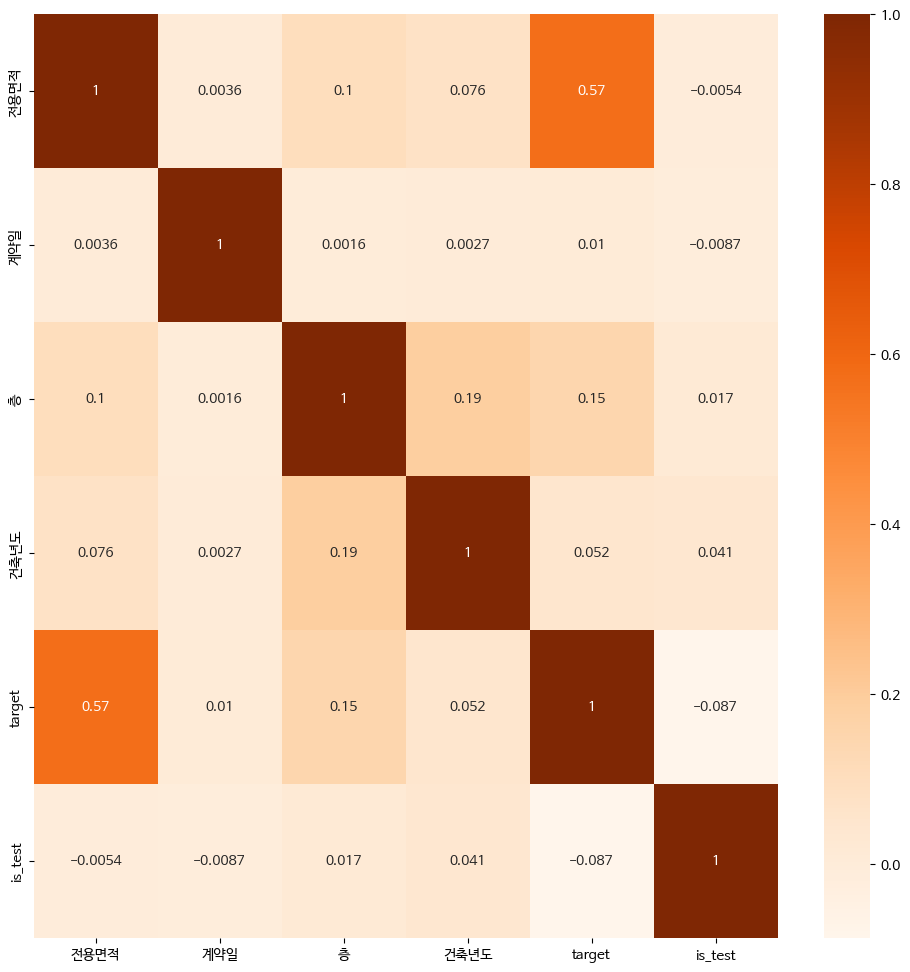

In [159]:

plt.figure(figsize=(12,12))
ft_corr_matrix = concat_select.corr()
sns.heatmap(ft_corr_matrix, annot=True, cmap='Oranges')

In [160]:
value_sorted = ft_corr_matrix.unstack().sort_values(ascending=False)
value_sorted.drop_duplicates()[:20]

전용면적     전용면적       1.000000
target   전용면적       0.572950
층        건축년도       0.191310
target   층          0.150288
전용면적     층          0.103204
         건축년도       0.076168
target   건축년도       0.051858
is_test  건축년도       0.041288
층        is_test    0.017322
계약일      target     0.010029
         전용면적       0.003607
         건축년도       0.002657
         층          0.001629
전용면적     is_test   -0.005412
is_test  계약일       -0.008686
target   is_test   -0.087039
dtype: float64

In [161]:
concat_select.columns

Index(['번지', '본번', '부번', '아파트명', '전용면적', '계약일', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월'],
      dtype='object')

In [162]:
# 연속형 변수: ['전용면적', '계약일', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', '강남여부', '신축여부']
# 범주형 변수: ['번지', '본번', '부번', '아파트명', '도로명', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', '구', '동', '계약년', '계약월']
del_features = ['부번', '계약일', '계약월', '층']
concat_select_ft = concat_select.drop(del_features, axis=1)


In [163]:
concat_select_ft.columns

Index(['번지', '본번', '아파트명', '전용면적', '건축년도', '도로명', 'target', 'is_test', '구',
       '동', '계약년'],
      dtype='object')

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [164]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select_ft.query('is_test==0')
dt_test = concat_select_ft.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 10) (9272, 10)


In [165]:
dt_test.head(1)

,번지,본번,아파트명,전용면적,건축년도,도로명,target,구,동,계약년
0,658-1,658.0,개포6차우성,79.97,1987,언주로 3,13250.0,강남구,개포동,2023


In [166]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

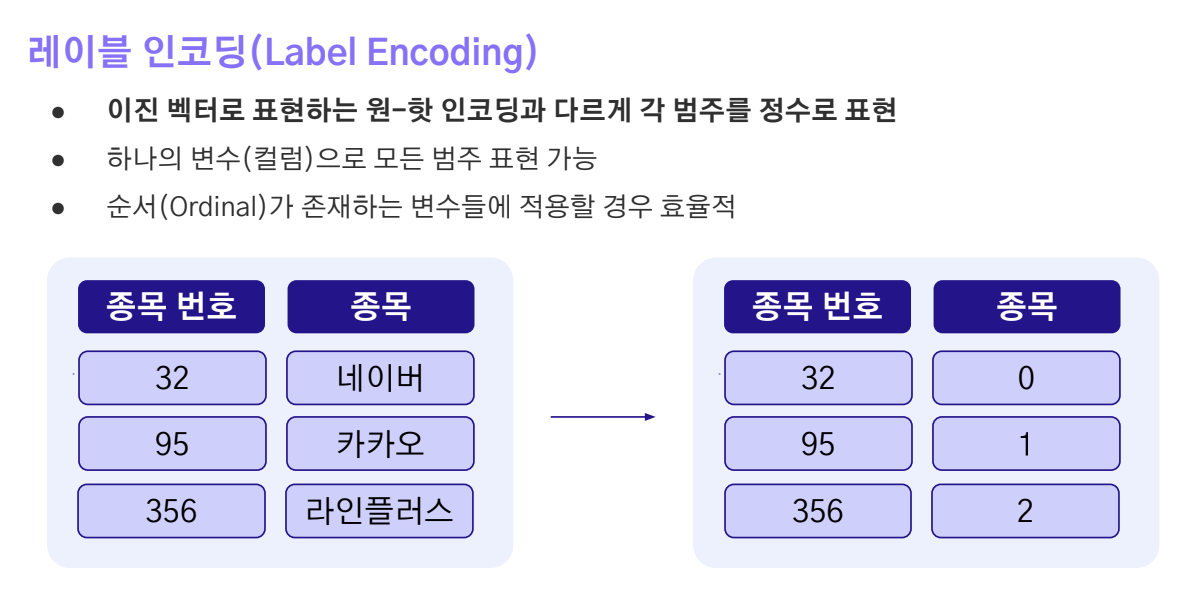

In [167]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '건축년도', 'target']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '구', '동', '계약년']


In [168]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


In [169]:
dt_train.head(1)        # 레이블인코딩이 된 모습입니다.

,번지,본번,아파트명,전용면적,건축년도,도로명,target,구,동,계약년
0,4732,1149,330,79.97,1987,6176,124000.0,0,8,10


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 RandomForest를 이용하겠습니다.
- Train과 Valid dataset을 분할하는 과정에서는 `holdout` 방법을 사용하겠습니다. 이 방법의 경우  대략적인 성능을 빠르게 확인할 수 있다는 점에서 baseline에서 사용해보도록 하겠습니다.
  - 이 후 추가적인 eda를 통해서 평가세트와 경향을 맞추거나 kfold와 같은 분포에 대한 고려를 추가할 수 있습니다.

In [170]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.


In [171]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [172]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)
# 5 -> 100

- 랜덤포레스트의 하이퍼파라미터도 데이터에 맞게 지정해줄 수 있습니다. 데이터에 맞는 하이퍼파라미터를 찾는 것도 성능 향상에 도움이 될 수 있습니다.

In [173]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 7597.503038435967


- 변수 중요도도 확인해보도록 하겠습니다.

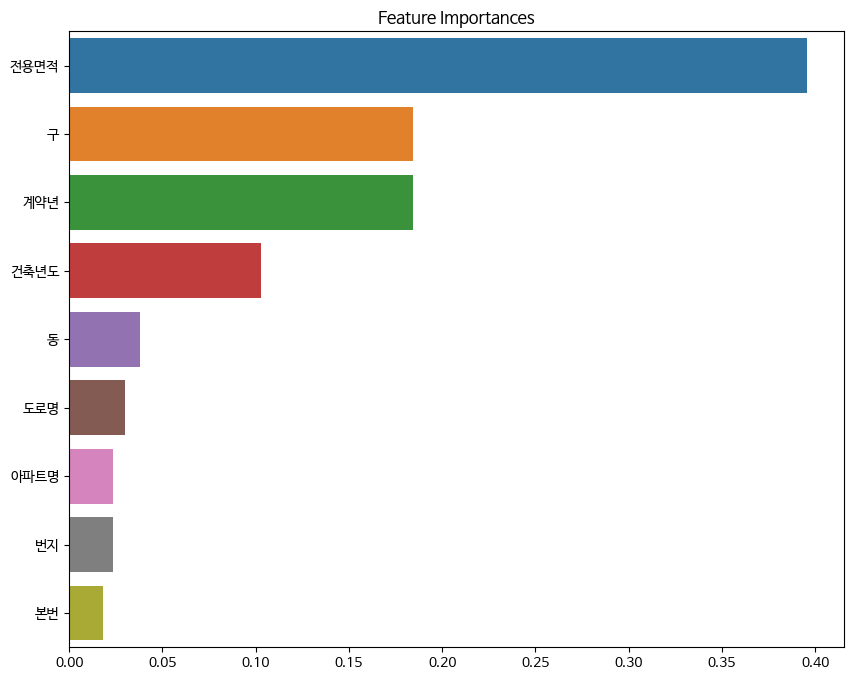

In [174]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [175]:
model.feature_importances_
importances

전용면적    0.395806
구       0.184362
계약년     0.184287
건축년도    0.102743
동       0.038189
도로명     0.029947
아파트명    0.023273
번지      0.023263
본번      0.018129
dtype: float64

In [176]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [177]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = 'neg_mean_squared_error',        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
1434568899.6605 ± 10045549.7923,전용면적
1117099939.0610 ± 5673990.2365,구
1062686908.5873 ± 8775800.8978,계약년
504602789.6984 ± 4321680.2232,건축년도
158120795.3872 ± 261429.8959,동
124176854.1558 ± 6375466.1662,도로명
72358074.2238 ± 2018806.4072,번지
70757533.9645 ± 1138270.3411,아파트명
39256746.6383 ± 1877411.9522,본번


- 분석 결과 "계약년", "전용면적" 변수가 유의한 변수로 보입니다. 따라서 이 변수로 또 다른 파생변수를 더 생성해보거나, 중요도가 낮아보이는 변수를 제거해 차원의 저주를 막아볼 수도 있습니다.

### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [178]:
# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [179]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors

In [180]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [181]:
X_val_sort.head()

,번지,본번,아파트명,전용면적,건축년도,도로명,구,동,계약년,target,pred,error
224567,745,222,112,273.9600,2020,5895,0,286,15,1450000.0,1.000703e+06,2.018676e+11
221950,3113,826,2105,227.3700,2019,8780,20,312,16,465000.0,8.587100e+05,1.550076e+11
203582,4878,1184,1693,224.3836,2006,8716,0,286,16,680000.0,3.391067e+05,1.162083e+11
287159,3284,853,4722,241.6230,2014,6970,20,239,14,280000.0,5.602159e+05,7.852093e+10
98806,4578,1114,5489,207.0900,2005,6202,0,181,5,89900.0,3.503836e+05,6.785170e+10


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [182]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [183]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [184]:
display(error_top100.head(1))
display(best_top100.head(1))

,번지,본번,아파트명,전용면적,건축년도,도로명,구,동,계약년,target,pred,error
224567,129,129.0,PH129,273.96,2020,압구정로79길 88,강남구,청담동,2022,1450000.0,1.000703e+06,2.018676e+11


,번지,본번,아파트명,전용면적,건축년도,도로명,구,동,계약년,target,pred,error
904221,577-16,577.0,명남더블레스,51.28,2012,응암로 215,은평구,응암동,2013,27800.0,27800.0,0.0


- 이제 분포를 비교해보도록 하겠습니다.

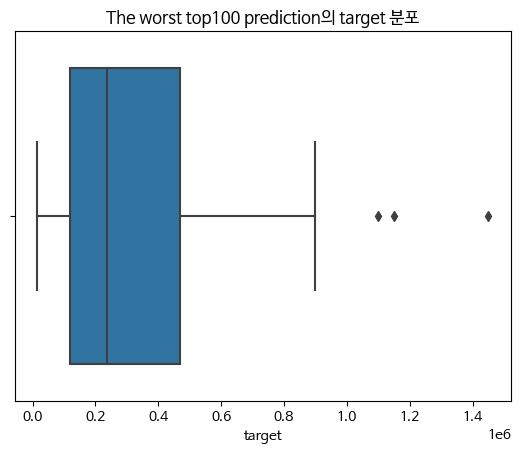

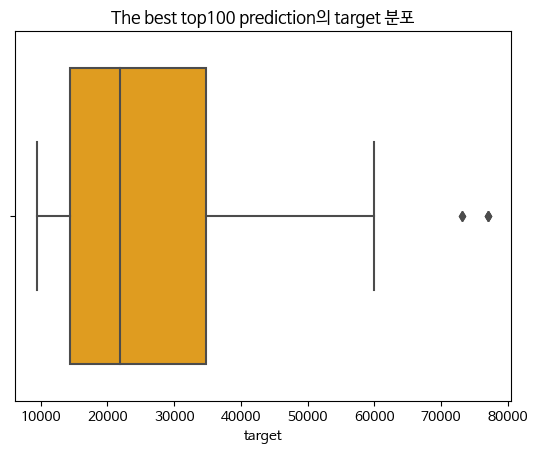

In [185]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

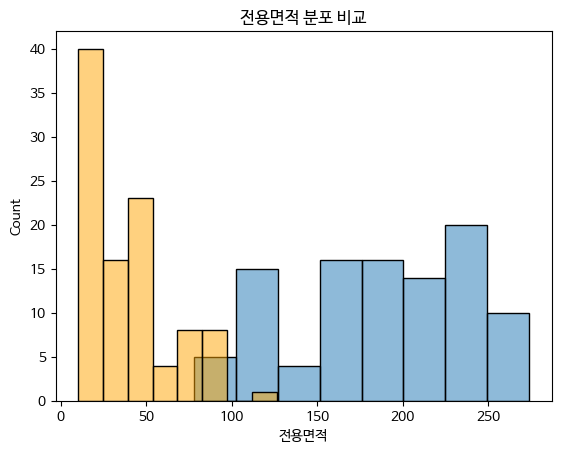

In [187]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [188]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,번지,본번,아파트명,전용면적,건축년도,도로명,target,구,동,계약년
0,4732,1149,330,79.9700,1987,6176,0,0,8,16
1,4707,1142,331,108.2017,2021,469,0,0,8,16


In [189]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [190]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 187 ms, sys: 141 µs, total: 187 ms
Wall time: 39.7 ms


In [191]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([207335.10822511, 320721.74666667, 337042.71428571, ...,
        78554.04      ,  68914.37698413,  68298.91666667])

## 7. Output File Save

In [192]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_few9_features_apt.csv', index=False)